In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup

In [15]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")

try:
    from plotting import make_vae_plots
except Exception as ex:
    print(f"If using Colab, you may need to upload `plotting.py`. \
          \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer \
          \n---------------------------------------------")
    print(ex)

If using Colab, you may need to upload `plotting.py`.           
In the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer           
---------------------------------------------
No module named 'plotting'


In [16]:
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        return self.mu + self.sigma * self.sample_epsilon()
        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        epsilon = (z-self.mu)/self.sigma
        return -1/2*epsilon**2-self.sigma.log()-(1/2)*math.log(2*math.pi)  

# Data

In [17]:
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision import transforms, utils
from functools import reduce

# Flatten the images into a vector
flatten = lambda x: ToTensor()(x).view(28**2)
from torch.distributions import Bernoulli
binarization = lambda x: torch.bernoulli(x)
c_transform  = transforms.Compose([flatten,binarization])

# Define the train and test sets
dset_train = MNIST("./", train=True,  transform=c_transform, download=True)
dset_test  = MNIST("./", train=False, transform=c_transform)

# The digit classes to use
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

batch_size = 64
eval_batch_size = 64
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.train_labels))
test_loader  = DataLoader(dset_test, batch_size=eval_batch_size, 
                          sampler=stratified_sampler(dset_test.test_labels))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


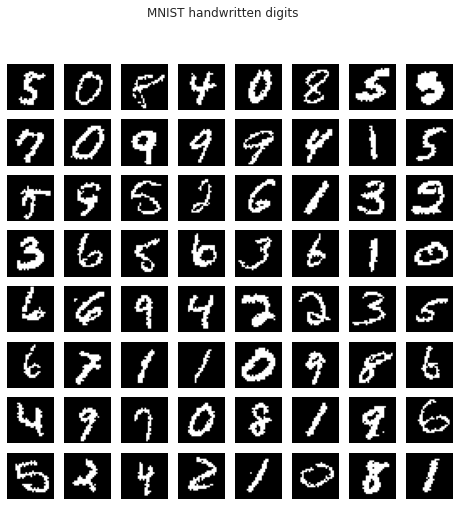

In [18]:
#plot a few MNIST examples
f, axarr = plt.subplots(8, 8, figsize=(8, 8))

# Load a batch of images into memory
images, labels = next(iter(train_loader))

for i, ax in enumerate(axarr.flat):
    ax.imshow(images[i].view(28, 28), cmap="binary_r")
    ax.axis('off')
    
plt.suptitle('MNIST handwritten digits')
plt.show()

# Model

In [19]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=128, out_features=2*latent_features) 
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=self.observation_features)
        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))
        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encoder(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        return Bernoulli(logits=px_logits)
        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # degine the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'z': z}


latent_features = 2
vae = VariationalAutoencoder(images[0].shape, latent_features)
print(vae)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [20]:
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z)`
        kl = log_qz - log_pz
        elbo = log_px - kl # <- your code here
        beta_elbo = log_px - self.beta*kl # <- your code here

        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs
        

In [21]:
vi = VariationalInference(beta=1.0)
loss, diagnostics, outputs = vi(vae, images)
print(f"{'loss':6} | mean = {loss:10.3f}, shape: {list(loss.shape)}")
for key, tensor in diagnostics.items():
    print(f"{key:6} | mean = {tensor.mean():10.3f}, shape: {list(tensor.shape)}")

loss   | mean =    543.335, shape: []
elbo   | mean =   -543.335, shape: [64]
log_px | mean =   -543.330, shape: [64]
kl     | mean =      0.004, shape: [64]


# Training and Test

In [22]:
from collections import defaultdict
# define the models, evaluator and optimizer

# VAE
latent_features = 4 #2
vae = VariationalAutoencoder(images[0].shape, latent_features)

# Evaluator: Variational Inference
beta = 1
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

>> Using device: cuda:0


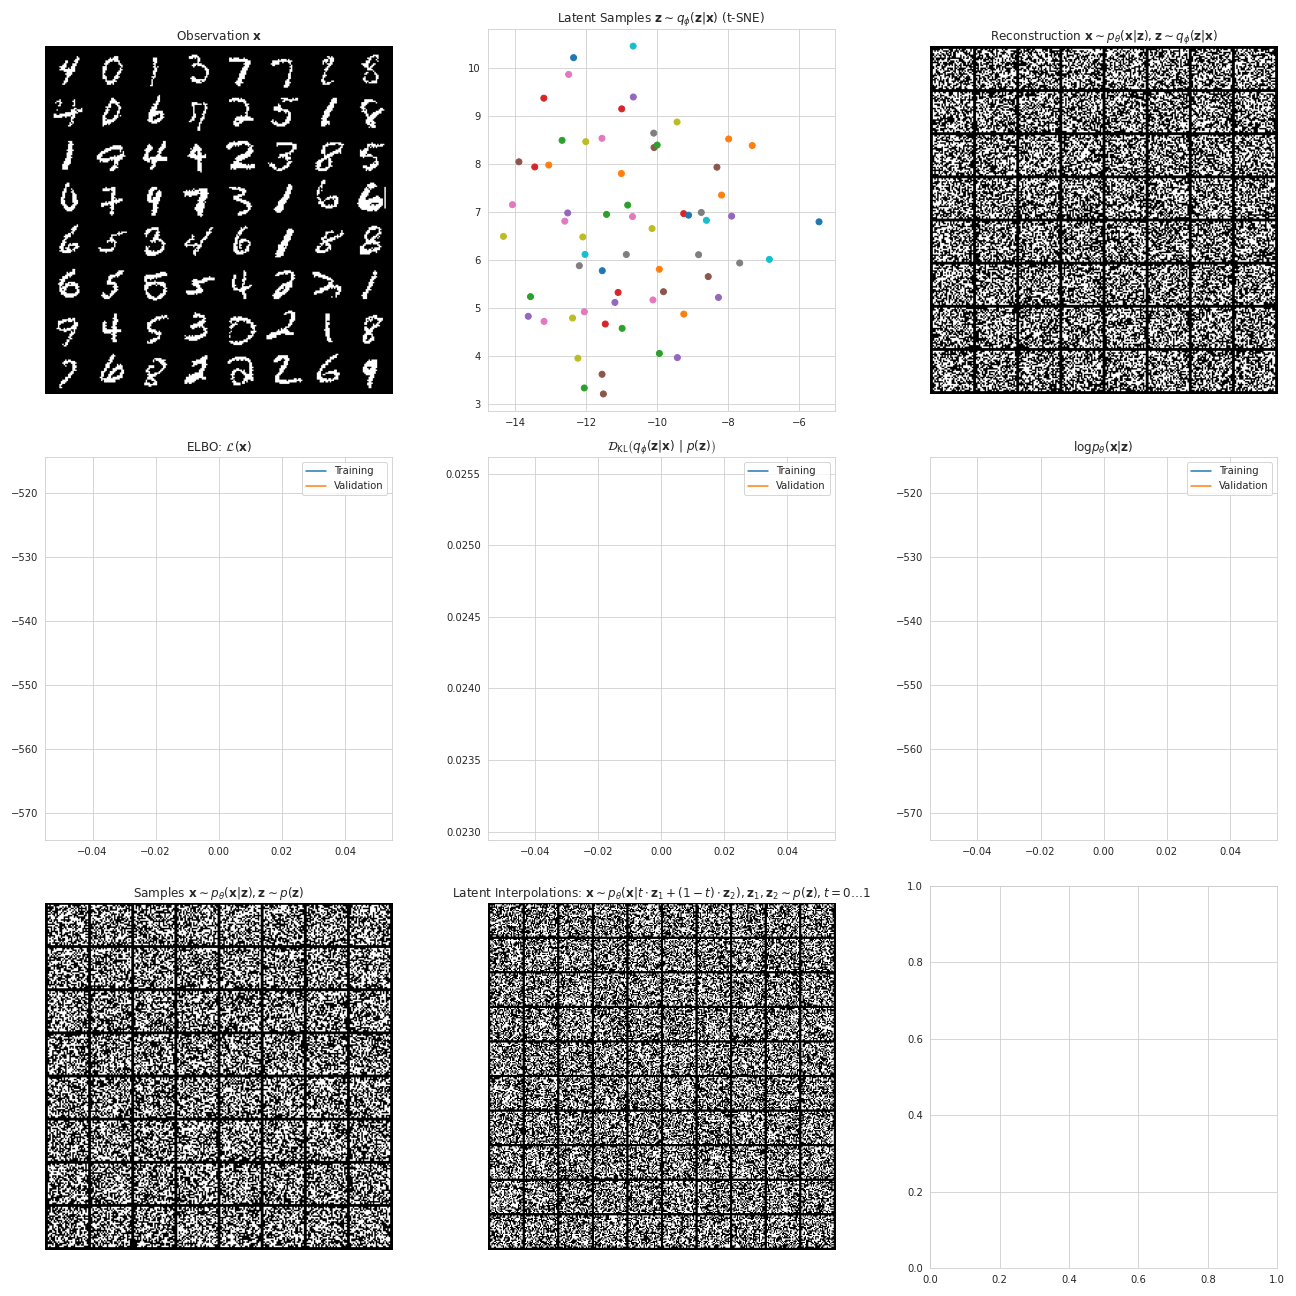

In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

vae = vae.to(device)
with torch.no_grad():
  vae.eval()
  x, y = next(iter(test_loader))
  x = x.to(device)
  loss, diagnostics, outputs = vi(vae, x)
  for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
make_vae_plots(vae, x, y, outputs, training_data, validation_data)          

In [58]:
diagnostics['kl'].mean()

tensor(0.0243, device='cuda:0')

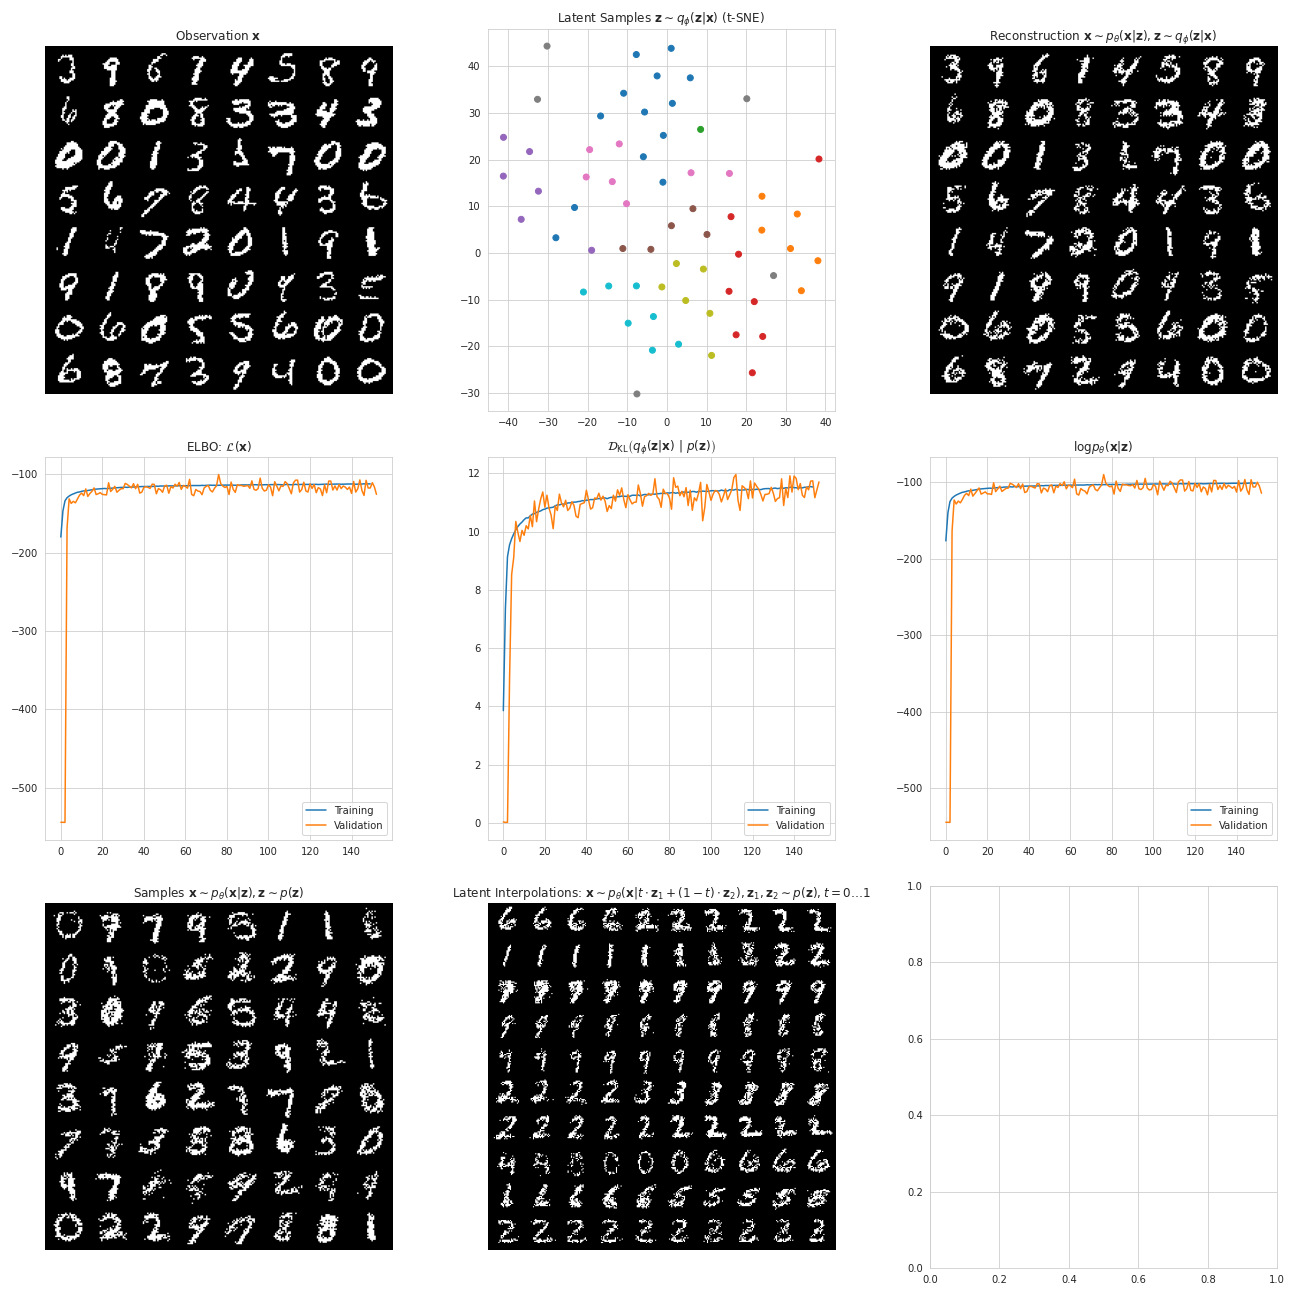

In [44]:
num_epochs = 150

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)

# training..
while epoch < num_epochs:
    epoch+= 1
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in train_loader:
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]
            

    # gather data for the full epoch
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
    
    # Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
    make_vae_plots(vae, x, y, outputs, training_data, validation_data)

In [48]:
diagnostics['kl'].mean()

tensor(11.7032, device='cuda:0')

In [52]:
#path = "drive//My Drive/Vae4.pth"
#torch.save(vae, path)
#path = "drive//My Drive/Vae4.pt"
#torch.save(vae, path)

In [ ]:
#vae = torch.load("drive/My Drive/Vae.pt")

# M1 - 100 points

Extract 100 labeled datapoints from MNIST (10 from each class).

In [83]:
r_images = torch.load("drive//My Drive/Vae/r_images.pt")
r_labels = torch.load("drive//My Drive/Vae/r_labels.pt")

In [84]:
vae = torch.load("drive/My Drive/Vae/Vae32.pt")
vae = vae.to(device)
with torch.no_grad():
  vae.eval()
  x = r_images
  y = r_labels
  x = x.to(device)  
  loss, diagnostics, outputs = vi(vae, x)
  for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
#make_vae_plots(vae, x, y, outputs, training_data, validation_data)

z = outputs['z']
z = z.to('cpu')
y = y.to('cpu')
z = z.detach()
z.requires_grad=True
r_labels = r_labels.type(torch.LongTensor)

In [85]:
import torch.optim as optim
import random

input_size = 32
hidden_sizes = [64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, output_size))
#print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(20):
  running_loss = 0
  for j in range(10000):
    randomlist = []
    for i in range(0,100):
      n = random.randint(0,99)
      randomlist.append(n)
    images = z[randomlist,]        #[(range(rand1,rand2+1)),]
    labels = r_labels[randomlist] #[rand1:rand2]

    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  print('[%d] loss: %.3f' % (epoch, running_loss/10000) )

[0] loss: 0.256
[1] loss: 0.049
[2] loss: 0.029
[3] loss: 0.021
[4] loss: 0.016
[5] loss: 0.013
[6] loss: 0.011
[7] loss: 0.010
[8] loss: 0.009
[9] loss: 0.008
[10] loss: 0.007
[11] loss: 0.006
[12] loss: 0.006
[13] loss: 0.005
[14] loss: 0.005
[15] loss: 0.005
[16] loss: 0.005
[17] loss: 0.004
[18] loss: 0.004
[19] loss: 0.004


In [86]:
path = "drive//My Drive/M1_LC_LS32.pth"
torch.save(model, path)

In [87]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        x = images.to(device)  
        loss, diagnostics, outputs = vi(vae, x)
        nz = outputs['z']
        nz = nz.to('cpu')
        nz = nz.detach()
        nz.requires_grad=True

        output = model(nz)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: %f %%' % (100 * correct / total))

Accuracy: 43.940000 %


In [88]:
input_size = 32
hidden_sizes = [128*2,64*2]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size))
#print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(20):
  running_loss = 0
  for j in range(10000):
    randomlist = []
    for i in range(0,100):
      n = random.randint(0,99)
      randomlist.append(n)
    images = z[randomlist,]        #[(range(rand1,rand2+1)),]
    labels = r_labels[randomlist] #[rand1:rand2]

    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  print('[%d] loss: %.3f' % (epoch, running_loss/10000) )

[0] loss: 0.150
[1] loss: 0.002
[2] loss: 0.001
[3] loss: 0.001
[4] loss: 0.000
[5] loss: 0.000
[6] loss: 0.000
[7] loss: 0.000
[8] loss: 0.000
[9] loss: 0.000
[10] loss: 0.000
[11] loss: 0.000
[12] loss: 0.000
[13] loss: 0.000
[14] loss: 0.000
[15] loss: 0.000
[16] loss: 0.000
[17] loss: 0.000
[18] loss: 0.000
[19] loss: 0.000


In [89]:
path = "drive//My Drive/M1_NN_LS32.pth"
torch.save(model, path)

In [90]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        x = images.to(device)  
        loss, diagnostics, outputs = vi(vae, x)
        nz = outputs['z']
        nz = nz.to('cpu')
        nz = nz.detach()
        nz.requires_grad=True

        output = model(nz)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: %f %%' % (100 * correct / total))

Accuracy: 48.570000 %


VAE8

In [91]:
vae = torch.load("drive/My Drive/Vae/Vae8.pt")
vae = vae.to(device)
with torch.no_grad():
  vae.eval()
  x = r_images
  y = r_labels
  x = x.to(device)  
  loss, diagnostics, outputs = vi(vae, x)
  for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
#make_vae_plots(vae, x, y, outputs, training_data, validation_data)

z = outputs['z']
z = z.to('cpu')
y = y.to('cpu')
z = z.detach()
z.requires_grad=True
r_labels = r_labels.type(torch.LongTensor)

In [92]:
import torch.optim as optim
import random

input_size = 8
hidden_sizes = [64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, output_size))
#print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(20):
  running_loss = 0
  for j in range(10000):
    randomlist = []
    for i in range(0,100):
      n = random.randint(0,99)
      randomlist.append(n)
    images = z[randomlist,]        #[(range(rand1,rand2+1)),]
    labels = r_labels[randomlist] #[rand1:rand2]

    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  print('[%d] loss: %.3f' % (epoch, running_loss/10000) )

[0] loss: 0.561
[1] loss: 0.242
[2] loss: 0.174
[3] loss: 0.137
[4] loss: 0.115
[5] loss: 0.099
[6] loss: 0.087
[7] loss: 0.078
[8] loss: 0.070
[9] loss: 0.064
[10] loss: 0.059
[11] loss: 0.055
[12] loss: 0.052
[13] loss: 0.048
[14] loss: 0.045
[15] loss: 0.043
[16] loss: 0.041
[17] loss: 0.039
[18] loss: 0.037
[19] loss: 0.035


In [93]:
path = "drive//My Drive/M1_LC_LS8.pth"
torch.save(model, path)

In [94]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        x = images.to(device)  
        loss, diagnostics, outputs = vi(vae, x)
        nz = outputs['z']
        nz = nz.to('cpu')
        nz = nz.detach()
        nz.requires_grad=True

        output = model(nz)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: %f %%' % (100 * correct / total))

Accuracy: 71.410000 %


In [95]:
input_size = 8
hidden_sizes = [128*2,64*2]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size))
#print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(20):
  running_loss = 0
  for j in range(10000):
    randomlist = []
    for i in range(0,100):
      n = random.randint(0,99)
      randomlist.append(n)
    images = z[randomlist,]        #[(range(rand1,rand2+1)),]
    labels = r_labels[randomlist] #[rand1:rand2]

    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  print('[%d] loss: %.3f' % (epoch, running_loss/10000) )

[0] loss: 0.135
[1] loss: 0.004
[2] loss: 0.002
[3] loss: 0.001
[4] loss: 0.001
[5] loss: 0.001
[6] loss: 0.000
[7] loss: 0.000
[8] loss: 0.000
[9] loss: 0.000
[10] loss: 0.000
[11] loss: 0.000
[12] loss: 0.000
[13] loss: 0.000
[14] loss: 0.000
[15] loss: 0.000
[16] loss: 0.000
[17] loss: 0.000
[18] loss: 0.000
[19] loss: 0.000


In [96]:
path = "drive//My Drive/M1_NN_LS8.pth"
torch.save(model, path)

In [97]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        x = images.to(device)  
        loss, diagnostics, outputs = vi(vae, x)
        nz = outputs['z']
        nz = nz.to('cpu')
        nz = nz.detach()
        nz.requires_grad=True

        output = model(nz)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: %f %%' % (100 * correct / total))

Accuracy: 71.390000 %


VAE4

In [98]:
vae = torch.load("drive/My Drive/Vae/Vae4.pt")
vae = vae.to(device)
with torch.no_grad():
  vae.eval()
  x = r_images
  y = r_labels
  x = x.to(device)  
  loss, diagnostics, outputs = vi(vae, x)
  for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
#make_vae_plots(vae, x, y, outputs, training_data, validation_data)

z = outputs['z']
z = z.to('cpu')
y = y.to('cpu')
z = z.detach()
z.requires_grad=True
r_labels = r_labels.type(torch.LongTensor)

In [99]:
import torch.optim as optim
import random

input_size = 4
hidden_sizes = [64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, output_size))
#print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(20):
  running_loss = 0
  for j in range(10000):
    randomlist = []
    for i in range(0,100):
      n = random.randint(0,99)
      randomlist.append(n)
    images = z[randomlist,]        #[(range(rand1,rand2+1)),]
    labels = r_labels[randomlist] #[rand1:rand2]

    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  print('[%d] loss: %.3f' % (epoch, running_loss/10000) )

[0] loss: 0.776
[1] loss: 0.404
[2] loss: 0.313
[3] loss: 0.264
[4] loss: 0.231
[5] loss: 0.206
[6] loss: 0.189
[7] loss: 0.174
[8] loss: 0.161
[9] loss: 0.152
[10] loss: 0.143
[11] loss: 0.136
[12] loss: 0.129
[13] loss: 0.123
[14] loss: 0.118
[15] loss: 0.113
[16] loss: 0.109
[17] loss: 0.105
[18] loss: 0.102
[19] loss: 0.098


In [100]:
path = "drive//My Drive/M1_LC_LS4.pth"
torch.save(model, path)

In [101]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        x = images.to(device)  
        loss, diagnostics, outputs = vi(vae, x)
        nz = outputs['z']
        nz = nz.to('cpu')
        nz = nz.detach()
        nz.requires_grad=True

        output = model(nz)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: %f %%' % (100 * correct / total))

Accuracy: 86.510000 %


In [1]:
input_size = 4
hidden_sizes = [128*2,64*2]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size))
#print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(20):
  running_loss = 0
  for j in range(10000):
    randomlist = []
    for i in range(0,100):
      n = random.randint(0,99)
      randomlist.append(n)
    images = z[randomlist,]        #[(range(rand1,rand2+1)),]
    labels = r_labels[randomlist] #[rand1:rand2]

    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  print('[%d] loss: %.3f' % (epoch, running_loss/10000) )

NameError: ignored

In [103]:
path = "drive//My Drive/M1_NN_LS4.pth"
torch.save(model, path)

In [104]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        x = images.to(device)  
        loss, diagnostics, outputs = vi(vae, x)
        nz = outputs['z']
        nz = nz.to('cpu')
        nz = nz.detach()
        nz.requires_grad=True

        output = model(nz)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: %f %%' % (100 * correct / total))

Accuracy: 86.720000 %


# M1 - Full trainingset

In [26]:
vae = torch.load("drive/My Drive/Vae/Vae4.pt")
r_images = torch.load("drive//My Drive/Vae/r_images.pt")
r_labels = torch.load("drive//My Drive/Vae/r_labels.pt")

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

vae = vae.to(device)
with torch.no_grad():
  vae.eval()
  x = r_images
  y = r_labels
  x = x.to(device)  
  loss, diagnostics, outputs = vi(vae, x)
  for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
#make_vae_plots(vae, x, y, outputs, training_data, validation_data)

z = outputs['z']
z = z.to('cpu')
y = y.to('cpu')
z = z.detach()
z.requires_grad=True
r_labels = r_labels.type(torch.LongTensor)

>> Using device: cuda:0


In [32]:
import torch.optim as optim
import random
input_size = 4
hidden_sizes = [64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, output_size))
#print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(30):
  running_loss = 0
  for images, labels in train_loader:
      vae = vae.to(device)
      with torch.no_grad():
        vae.eval()
        x = images
        y = labels
        x = x.to(device) 
        loss_t, diagnostics_t, outputs = vi(vae, x)
      z = outputs['z']
      z = z.to('cpu')
      z.requires_grad=True

      optimizer.zero_grad()
      output = model(z)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
  print('[%d] loss: %.3f' % (epoch, running_loss) )

[0] loss: 1725.308
[1] loss: 1146.150
[2] loss: 958.286
[3] loss: 860.562
[4] loss: 796.689
[5] loss: 751.880
[6] loss: 716.734
[7] loss: 688.145
[8] loss: 665.087
[9] loss: 646.480
[10] loss: 631.730
[11] loss: 616.300
[12] loss: 601.772
[13] loss: 593.281
[14] loss: 581.854
[15] loss: 574.864
[16] loss: 567.036
[17] loss: 558.530
[18] loss: 552.390
[19] loss: 546.389
[20] loss: 541.481
[21] loss: 535.389
[22] loss: 529.600
[23] loss: 526.576
[24] loss: 521.116
[25] loss: 517.645
[26] loss: 513.998
[27] loss: 509.761
[28] loss: 507.451
[29] loss: 503.796


In [33]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        x = images.to(device)  
        loss, diagnostics, outputs = vi(vae, x)
        nz = outputs['z']
        nz = nz.to('cpu')
        nz = nz.detach()
        nz.requires_grad=True

        output = model(nz)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: %f %%' % (100 * correct / total))

Accuracy: 90.200000 %


In [35]:
input_size = 4
hidden_sizes = [128*2,64*2]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(30):
  running_loss = 0
  for images, labels in train_loader:
      vae = vae.to(device)
      with torch.no_grad():
        vae.eval()
        x = images
        y = labels
        x = x.to(device) 
        loss_t, diagnostics_t, outputs = vi(vae, x)
      z = outputs['z']
      z = z.to('cpu')
      z.requires_grad=True

      optimizer.zero_grad()
      output = model(z)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
  print('[%d] loss: %.3f' % (epoch, running_loss) )

[0] loss: 1031.886
[1] loss: 444.882
[2] loss: 358.937
[3] loss: 325.052
[4] loss: 307.860
[5] loss: 298.900
[6] loss: 289.501
[7] loss: 282.161
[8] loss: 276.368
[9] loss: 269.411
[10] loss: 264.220
[11] loss: 257.506
[12] loss: 254.194
[13] loss: 252.083
[14] loss: 246.452
[15] loss: 243.292
[16] loss: 237.858
[17] loss: 238.372
[18] loss: 234.750
[19] loss: 230.299
[20] loss: 229.651
[21] loss: 226.782
[22] loss: 224.364
[23] loss: 225.388
[24] loss: 222.372
[25] loss: 220.338
[26] loss: 217.398
[27] loss: 218.580
[28] loss: 214.308
[29] loss: 214.732


In [36]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        x = images.to(device)  
        loss, diagnostics, outputs = vi(vae, x)
        nz = outputs['z']
        nz = nz.to('cpu')
        nz = nz.detach()
        nz.requires_grad=True

        output = model(nz)
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: %f %%' % (100 * correct / total))

Accuracy: 94.840000 %
